In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *
import time
#mean squared error: 0.00302
#params=np.array([\
# 1.00019169, 1.00485457, 0.98089897,\
# 0.00173489, 0.03556878, 0.19213672,\
# 0.99867178, 0.00847006, 0.02213006, 0.12979466]

#msqerr: 0.0029
#[ 1.0003588   1.00501068  0.98071385  0.00298074  0.0019567   0.20618256
#  1.03816403 -0.02316948 -0.01194352  0.12074971]

#msqerr: 0.0016
#[ 1.00019457  1.00488652  0.98081785  0.00157861  0.03279509  0.19761574
#  0.99666972  0.00134338  0.0370082  -0.02798724]

In [2]:
#Read in the raw data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()


Successfully loaded  Ch80_8g_DC_Acceleration.csv
Successfully loaded  Ch32_16g_DC_Acceleration.csv
Successfully loaded  Ch43_IMU_Acceleration.csv
Successfully loaded  Ch47_Rotation.csv
Successfully loaded  Ch51_IMU_Magnetic_Field.csv


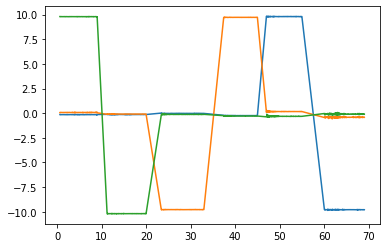

In [3]:
## Find the intervals where the sensor is stationary
intervals=[\
          (0.6,9),\
          (11.2,20),\
          (23.4,33),\
          (37.4,45),\
          (47,55),\
          (60,69),\
          ]       


ts_0,acc_0=idx_filter(ts,acc,intervals)
plt.plot(ts_0,acc_0)

In [7]:
params=[ 1.00019457,  1.00488652,  0.98081785,  \
        0.00157861,  0.03279509,   0.19761574,  \
        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

In [6]:
#params=[scale0,scale1,scale2,bias1,bias2,bias3,qw,qx,qy,qz]

#Initial guess
#params=np.array([\
#    1.0,1.0,1.0,\
#    0.0,0.0,0.0,\
#    1.0,0.0,0.0,0.0 \
#    ])

#ACC 8
#([ 1.00019457,  1.00488652,  0.98081785,  0.00157861,  0.03279509,
#        0.19761574,  0.99666972,  0.00134338,  0.0370082 , -0.02798724])

#ACC16
#([ 0.99947972,  0.9985753 ,  1.0101357 ,  0.163847  ,  0.57478074,
#        0.44491193,  0.99663155,  0.00126076,  0.03802838, -0.02799045])

#ACCIMU

#Use the last best guess
params=[ 1.00019457,  1.00488652,  0.98081785,  \
        0.00157861,  0.03279509,   0.19761574,  \
        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

print(msqError(params,intervals,acc,gyro,mag,ts))

##Allocate arrays once for speedup
#workspace={}
#num_samples=len(ts)
#workspace['acc_scratch']=np.zeros((num_samples,3))
#workspace['Q']=np.tile(np.array([1.0,0.0,0.0,0.0]),(num_samples,1))
#workspace['Q_quat']=np.tile(Quaternion(np.array([1.0,0.0,0.0,0.0])),(num_samples,1))
#workspace['acc_lab']=np.zeros((num_samples,3))
#func = lambda params: msqError(params,intervals,acc,gyro,mag,ts,workspace=workspace)


##Takes 223 seconds to compute with preallocation
## 209 seconds without preallocation
func = lambda params: msqError(params,intervals,acc,gyro,mag,ts)

tic=time.time()
sol=minimize(func,params)
toc=time.time()

print(f"Minimization took {toc-tic:0.1f} seconds")
print(sol)

0.0016264259775090792
Minimization took 98.8 seconds
      fun: 0.001626425977503762
 hess_inv: array([[ 0.98847461,  0.10947308, -0.10278721, -0.01624638, -0.0067485 ,
         0.13280081, -0.01103984,  0.01101422,  0.06174383, -0.00730607],
       [ 0.10947308,  0.73692225,  0.32035331,  0.01927156,  0.08492389,
        -0.24029884,  0.11712285, -0.04310952,  0.07028642,  0.03312684],
       [-0.10278721,  0.32035331,  0.63727362, -0.03084579, -0.07777108,
         0.32203837, -0.108812  ,  0.04628448, -0.00398095, -0.03452834],
       [-0.01624638,  0.01927156, -0.03084579,  1.00057728, -0.01313318,
         0.00967144, -0.01769374,  0.0048321 , -0.02714735, -0.00399303],
       [-0.0067485 ,  0.08492389, -0.07777108, -0.01313318,  0.9966068 ,
         0.10513399, -0.00613546,  0.00809817,  0.05376006, -0.00525029],
       [ 0.13280081, -0.24029884,  0.32203837,  0.00967144,  0.10513399,
         0.81213579,  0.14332523, -0.04605277,  0.15192358,  0.0365046 ],
       [-0.01103984,  

Text(0, 0.5, 'lab frame acceleration (m/s^2)')

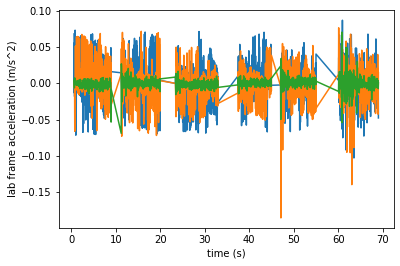

In [8]:

#params=sol.x
q=np.array(params[6:])
q/=np.linalg.norm(q)
q0=Quaternion(q)

## Apply scale-bias calibration
acc_calibrated=calibrate(acc,params=params)
acc_1=calibrate(acc_0,params=params)
# Rotate into lab frame using initial orientation
for i in range(len(acc_calibrated)):
    acc_calibrated[i]=q0.rotate(acc_calibrated[i])

#plt.plot(ts,acc_calibrated)

# Use madgwick filter to estimate orientation, and integrate to find position estimate
ACC_LAB,QIMU,state=apply_ahrs(gyro,acc_calibrated,mag,ts,q0=q,g=[0,0,9.799],position=True)

#Plot the quiet parts of the calibration data
ts_0,ACC_LAB0=idx_filter(ts,ACC_LAB,intervals)
plt.plot(ts_0,ACC_LAB0)
plt.xlabel("time (s)")
plt.ylabel("lab frame acceleration (m/s^2)")

In [49]:
print(intervals)

def variance_on_intervals(data,times,intervals):
    """
    compute the variance of data (along axis0) subject to the idx filter
    data: time series of data n x m array
    times: time stamps of the data, nx1 array
    intervals: list of tuples defining the time intervals
    
    """
    for interval in intervals:
        print(np.var(data[(times> interval[0] ) & (times < interval[1]),:],axis=0))
        

variance_on_intervals(acc,ts,intervals)
variance_on_intervals(acc_0,ts_0,intervals)
variance_on_intervals(gyro,ts,intervals)

[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]
[4.43532233e-05 5.19169818e-05 3.47391991e-05]
[7.80948796e-05 3.00735379e-05 6.27030266e-05]
[3.79405223e-05 2.20036747e-05 6.33484977e-05]
[5.84302716e-05 1.57548978e-05 6.78113105e-05]
[5.76120068e-05 2.95071803e-04 6.81049678e-04]
[0.00017619 0.00141769 0.00165952]
[4.43532233e-05 5.19169818e-05 3.47391991e-05]
[7.80948796e-05 3.00735379e-05 6.27030266e-05]
[3.79405223e-05 2.20036747e-05 6.33484977e-05]
[5.84302716e-05 1.57548978e-05 6.78113105e-05]
[5.76120068e-05 2.95071803e-04 6.81049678e-04]
[0.00017619 0.00141769 0.00165952]
[3.76901439e-07 5.80951434e-07 4.27050460e-07]
[5.81367998e-07 9.29546189e-07 4.74570548e-07]
[3.39872060e-07 8.12534799e-07 4.62394419e-07]
[3.79043674e-07 7.09049587e-07 3.53676630e-07]
[4.70376380e-07 2.16514181e-06 6.34045274e-07]
[3.30846976e-07 1.54111959e-05 5.57547257e-06]


In [59]:
a=1.0
b=2
print(f"The value of a is {a:1.2f} and the value of b is {b}")

The value of a is 1.00 and the value of b is 2


In [9]:
#Reordering
acc0x,acc1x,acc0y,acc1y,acc0z,acc1z=[acc_0[0][0]],[acc_1[0][0]],[acc_0[0][1]],[acc_1[0][1]],[acc_0[0][2]],[acc_1[0][2]]
gyrox,gyroy,gyroz=[[gyro[0][0]],[gyro[0][1]],[gyro[0][2]]]
accf = [[acc0x,acc0y,acc0z],[acc1x,acc1y,acc1z]]
gyrof=[gyrox,gyroy,gyroz]
for i in range(1,len(acc_0)):
        for k in [0,1,2]:
            accf[0][k].append(acc_0[i][k])
            accf[1][k].append(acc_1[i][k])
            gyrof[k].append(gyro[i][k])
            
            
#Variances
for i in [0,1]:
    if i==0: print("Before Calibration")
    else: print("Post Calibration")
    print("X Mean " + str(np.mean(accf[i][0][432:673])) + " Variance " + str(np.var(accf[i][0][432:673])))
    print("Y Mean " + str(np.mean(accf[i][1][864:1300])) + " Variance " + str(np.var(accf[i][1][864:1300])))
    print("Z Mean " + str(np.mean(accf[i][2][432:673])) + " Variance " + str(np.var(accf[i][2][432:673])))
    print(" ")

print("Gyroscope")
print("X Mean " + str(np.mean(gyrof[0][583:855])) + " Variance " + str(np.var(gyrof[0][583:855])))
print("Y Mean " + str(np.mean(gyrof[1][583:855])) + " Variance " + str(np.var(gyrof[1][583:855])))
print("Z Mean " + str(np.mean(gyrof[2][583:855])) + " Variance " + str(np.var(gyrof[2][583:855])))

Before Calibration
X Mean -0.02610191344605809 Variance 3.794052231620003e-05
Y Mean -0.14359739161124122 Variance 0.08477044021011895
Z Mean -0.12716825053941908 Variance 6.334849766450069e-05
 
Post Calibration
X Mean -0.024528382095357286 Variance 3.795528792738689e-05
Y Mean -0.11150399313729732 Variance 0.08560092926826891
Z Mean 0.07288684991766564 Variance 6.094148628431955e-05
 
Gyroscope
X Mean 0.00019973657042901357 Variance 3.418428007189658e-07
Y Mean -0.0002800227426850185 Variance 7.820620896256255e-07
Z Mean -0.0005012996277434066 Variance 4.5585175381916197e-07


# Variances

## 8g Accelerometer
#### Before Calibration
X Mean -0.02610191344605809 Variance 3.794052231620003e-05 <br>
Y Mean -0.14359739161124122 Variance 0.08477044021011895 <br>
Z Mean -0.12716825053941908 Variance 6.334849766450069e-05 <br>
 
#### Post Calibration
X Mean -0.024528382048952718 Variance 3.7955287928639906e-05 <br>
Y Mean -0.11150399308928384 Variance 0.08560092921846203 <br>
Z Mean 0.072886849515987 Variance 6.0941486316839465e-05 <br>

## 16g Accelerometer
#### Before Calibration
X Mean -0.14096203041908714 Variance 0.001426752407185179 <br>
Y Mean -0.702818565025761 Variance 0.13787802246844177 <br>
Z Mean -0.5921365742240664 Variance 0.008469381518042525 <br>
 
#### Post Calibration
X Mean 0.022958312096298922 Variance 0.0014252681781532466 <br>
Y Mean -0.12703652302255156 Variance 0.13748543301538543 <br>
Z Mean -0.15322636398952388 Variance 0.008641937787339656 <br>

## Gyroscope
X Mean 0.00019973657042901357 Variance 3.418428007189658e-07 <br>
Y Mean -0.0002800227426850185 Variance 3.418428007189658e-07 <br>
Z Mean -0.0005012996277434066 Variance 3.418428007189658e-07 <br>
<br>
<br>
Angular velocity of the Earth - 0.00007272205 <br>
Is smaller then the mean of any axis by atleast an order of magnitude, thus unlikely to be resolved

[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]


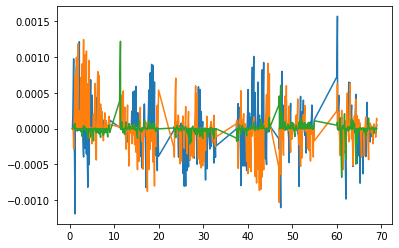

In [10]:
## Inspect the dead-reckoning position estimate
print(intervals)
ts_masked,state_masked=idx_filter(ts,state,intervals)
plt.plot(ts_masked,state_masked[:,0])
plt.plot(ts_masked,state_masked[:,1])
plt.plot(ts_masked,state_masked[:,2])

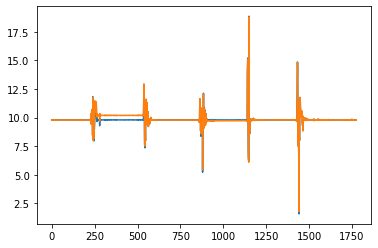

In [11]:
#Compare the uncalibrated vs calibrated acceleration magnitudes
plt.plot(np.sum(acc_calibrated**2,axis=1)**0.5  )
plt.plot(np.sum(acc**2,axis=1  )**0.5)